### Econscia NLP task 

In [1]:
#Importing required libraries

import keras
import numpy as np
import pandas as pd
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, GlobalMaxPooling1D
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
import csv
from keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import re                                       
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from random import shuffle
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [168]:
# Load data

data = pd.read_csv('austin_purchase_orders.csv')

In [3]:
data.shape

(28429, 13)

In [ ]:
data.head()

,PO_NUMBER,CONTRACT_NAME,EXTENDED_DESCRIPTION,QUANTITY,UNIT_OF_MEASURE,UNIT_OF_MEAS_DESC,UNIT_PRICE,TOTAL_PRICE,VENDOR_NAME,VENDOR_CITY,VENDOR_COUNTRY,COMMODITY_CODE,COMMODITY_DESCRIPTION
0,DOM1100MAX43377,Critical materials Supply Arrangement,"TRANSFORMER, DISTRIBUTION, SINGLE PHASE, POLE ...",2.0,EA,Each,1640.00000,3280.00,TECHLINE INC,AUSTIN,US,28586,"Transformers, Power Distribution (Incl. Fluid ..."
1,DOM1100MAX41029,forecasted jobs,"TRANSFORMER, PAD-MOUNTED, 3 PHASE, FEED THRU S...",2.0,EA,Each,10036.62000,20073.24,TECHLINE INC,AUSTIN,US,28586,"Transformers, Power Distribution (Incl. Fluid ..."
2,DO620013050813439,APAC Texas/ Hot Mix/ various sections,NaN,50.7,TON,Ton,56.00000,2839.20,APAC-TEXAS INC,Round Rock,US,7452114,"ASPHALTIC CONCRETE, HOT MIX, IN ACCORDANCE WIT..."
3,DO620010060321850,Apac/hotmix,NaN,201.3,TON,Ton,54.38003,10946.70,APAC-TEXAS INC,BELTON,US,7452114,"ASPHALTIC CONCRETE, HOT MIX, IN ACCORDANCE WIT..."
4,DOM1100MAX39131,Critical materials Supply Arrangement,"TRANSFORMER, DISTRIBUTION, SINGLE PHASE, PAD M...",1.0,EA,Each,2850.00000,2850.00,KBS ELECTRICAL DISTRIBUTORS INC,AUSTIN,US,28586,"Transformers, Power Distribution (Incl. Fluid ..."


In [ ]:
data.tail()

,PO_NUMBER,CONTRACT_NAME,EXTENDED_DESCRIPTION,QUANTITY,UNIT_OF_MEASURE,UNIT_OF_MEAS_DESC,UNIT_PRICE,TOTAL_PRICE,VENDOR_NAME,VENDOR_CITY,VENDOR_COUNTRY,COMMODITY_CODE,COMMODITY_DESCRIPTION
28424,DO640015080318050,RZ Communications quote RZ-Q-1054,Motorola Two-Way Radio Parts and Accessories ...,1.0,EA,Each,99.02,99.02,RZ COMMUNICATIONS INC,AUSTIN,US,72582,"Two-Way Radio Supplies, Parts, and Accessories"
28425,DO640015022509118,"RZ COMMUNICATIONS $10,210.03 SEE ATTACHED",Smart 2 Wire W/trans Tube Blk [pmln6129a],30.0,EA,Each,8.03,240.90,RZ COMMUNICATIONS INC,AUSTIN,US,72582,"Two-Way Radio Supplies, Parts, and Accessories"
28426,DO560011051316686,1099523-Ralph Warren- Microsoft Core Cals,Additional licenses 1099523-WINDOWS PRO UPS/S...,0.0,NaN,NaN,0.00,3859.46,"Summus Industries, Inc.",SUGAR LAND,US,20811,"Application Software, Microcomputer"
28427,DO150016011206100,RED WING Shoes/Boots - FY16,NaN,0.0,NaN,NaN,0.00,5000.00,RED WING BRANDS OF AMERICA INC,AUSTIN,US,80072,"Shoes, Safety Toe"
28428,PO640014050903586,Insight quote 215596805 U.S. COMMUNITIES,Insight quote 215596805 MR18-HW MERAKI HARDWA...,2.0,EA,Each,431.56,863.12,INSIGHT PUBLIC SECTOR INC,AUSTIN,US,20464,"Network Components: Adapter Cards, Bridges, Co..."


In [ ]:
data.isna()

,PO_NUMBER,CONTRACT_NAME,EXTENDED_DESCRIPTION,QUANTITY,UNIT_OF_MEASURE,UNIT_OF_MEAS_DESC,UNIT_PRICE,TOTAL_PRICE,VENDOR_NAME,VENDOR_CITY,VENDOR_COUNTRY,COMMODITY_CODE,COMMODITY_DESCRIPTION
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28424,False,False,False,False,False,False,False,False,False,False,False,False,False
28425,False,False,False,False,False,False,False,False,False,False,False,False,False
28426,False,False,False,False,True,True,False,False,False,False,False,False,False
28427,False,False,True,False,True,True,False,False,False,False,False,False,False


In [ ]:
data.isna().sum()

PO_NUMBER                   0
CONTRACT_NAME               0
EXTENDED_DESCRIPTION     9475
QUANTITY                    0
UNIT_OF_MEASURE          5801
UNIT_OF_MEAS_DESC        5801
UNIT_PRICE                  0
TOTAL_PRICE                 0
VENDOR_NAME                 0
VENDOR_CITY               405
VENDOR_COUNTRY            405
COMMODITY_CODE              0
COMMODITY_DESCRIPTION       0
dtype: int64

In [ ]:
data.dtypes

PO_NUMBER                 object
CONTRACT_NAME             object
EXTENDED_DESCRIPTION      object
QUANTITY                 float64
UNIT_OF_MEASURE           object
UNIT_OF_MEAS_DESC         object
UNIT_PRICE               float64
TOTAL_PRICE              float64
VENDOR_NAME               object
VENDOR_CITY               object
VENDOR_COUNTRY            object
COMMODITY_CODE             int64
COMMODITY_DESCRIPTION     object
dtype: object

In [58]:
data.astype({"COMMODITY_CODE":'category'})
data.astype({"EXTENDED_DESCRIPTION":'string'})

,PO_NUMBER,CONTRACT_NAME,EXTENDED_DESCRIPTION,QUANTITY,UNIT_OF_MEASURE,UNIT_OF_MEAS_DESC,UNIT_PRICE,TOTAL_PRICE,VENDOR_NAME,VENDOR_CITY,VENDOR_COUNTRY,COMMODITY_CODE,COMMODITY_DESCRIPTION
0,DOM1100MAX43377,Critical materials Supply Arrangement,"TRANSFORMER, DISTRIBUTION, SINGLE PHASE, POLE ...",2.0,EA,Each,1640.00000,3280.00,TECHLINE INC,AUSTIN,US,28586,"Transformers, Power Distribution (Incl. Fluid ..."
1,DOM1100MAX41029,forecasted jobs,"TRANSFORMER, PAD-MOUNTED, 3 PHASE, FEED THRU S...",2.0,EA,Each,10036.62000,20073.24,TECHLINE INC,AUSTIN,US,28586,"Transformers, Power Distribution (Incl. Fluid ..."
2,DO620013050813439,APAC Texas/ Hot Mix/ various sections,<NA>,50.7,TON,Ton,56.00000,2839.20,APAC-TEXAS INC,Round Rock,US,7452114,"ASPHALTIC CONCRETE, HOT MIX, IN ACCORDANCE WIT..."
3,DO620010060321850,Apac/hotmix,<NA>,201.3,TON,Ton,54.38003,10946.70,APAC-TEXAS INC,BELTON,US,7452114,"ASPHALTIC CONCRETE, HOT MIX, IN ACCORDANCE WIT..."
4,DOM1100MAX39131,Critical materials Supply Arrangement,"TRANSFORMER, DISTRIBUTION, SINGLE PHASE, PAD M...",1.0,EA,Each,2850.00000,2850.00,KBS ELECTRICAL DISTRIBUTORS INC,AUSTIN,US,28586,"Transformers, Power Distribution (Incl. Fluid ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28424,DO640015080318050,RZ Communications quote RZ-Q-1054,Motorola Two-Way Radio Parts and Accessories ...,1.0,EA,Each,99.02000,99.02,RZ COMMUNICATIONS INC,AUSTIN,US,72582,"Two-Way Radio Supplies, Parts, and Accessories"
28425,DO640015022509118,"RZ COMMUNICATIONS $10,210.03 SEE ATTACHED",Smart 2 Wire W/trans Tube Blk [pmln6129a],30.0,EA,Each,8.03000,240.90,RZ COMMUNICATIONS INC,AUSTIN,US,72582,"Two-Way Radio Supplies, Parts, and Accessories"
28426,DO560011051316686,1099523-Ralph Warren- Microsoft Core Cals,Additional licenses 1099523-WINDOWS PRO UPS/S...,0.0,NaN,NaN,0.00000,3859.46,"Summus Industries, Inc.",SUGAR LAND,US,20811,"Application Software, Microcomputer"
28427,DO150016011206100,RED WING Shoes/Boots - FY16,<NA>,0.0,NaN,NaN,0.00000,5000.00,RED WING BRANDS OF AMERICA INC,AUSTIN,US,80072,"Shoes, Safety Toe"


Issues found in data -
1. Null values in the fields - EXTENDED_DESCRIPTION, UNIT_OF_MEASURE, UNIT_OF_MEAS_DESC
2. Wrong values for TOTAL_PRICE when QUANTITY = 0
3. COMMODITY_CODE column was not categorical
4. CONTRACT_NAME and EXTENDED_DESCRIPTION have same values for some samples
5. Same commodities sourced from different vendors
6. Too many Null values (9000+ for EXTENDED_DESCRIPTION)
7. Class imbalance in the range of thousands

In [ ]:
print('Labels:')
data['COMMODITY_CODE'].unique()

Labels:


array([  28586, 7452114,   72582,   20464,   28574,   80072,   20811,
         54523, 7450841,  555444])

Data distribution of labels:
28429


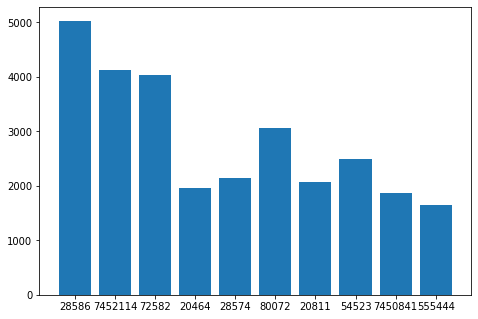

In [139]:
#Checking for class imbalance

print("Data distribution of labels:")
cc_28586 = data[data.COMMODITY_CODE == 28586].shape[0]
cc_7452114 = data[data.COMMODITY_CODE == 7452114].shape[0] 
cc_72582 = data[data.COMMODITY_CODE == 72582].shape[0]
cc_20464 = data[data.COMMODITY_CODE == 20464].shape[0]
cc_28574 = data[data.COMMODITY_CODE == 28574].shape[0]
cc_80072 = data[data.COMMODITY_CODE == 80072].shape[0]
cc_20811 = data[data.COMMODITY_CODE == 20811].shape[0]
cc_54523 = data[data.COMMODITY_CODE == 54523].shape[0]
cc_7450841 = data[data.COMMODITY_CODE == 7450841].shape[0]
cc_555444 = data[data.COMMODITY_CODE == 555444].shape[0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
class_labels = [  '28586', '7452114',   '72582',   '20464',   '28574',   '80072',   '20811',
         '54523', '7450841',  '555444']
values =[  cc_28586, cc_7452114,   cc_72582,   cc_20464,   cc_28574,   cc_80072,   cc_20811,
         cc_54523, cc_7450841,  cc_555444]
total = sum(values)
print(total)
ax.bar(class_labels,values)
plt.show()

In [169]:

#Handle missing values - https://stackoverflow.com/questions/55562696/how-to-replace-missing-values-with-group-mode-in-pandas

def fast_mode(df, key_cols, value_col):
    """ 
    Calculate a column mode, by group, ignoring null values. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame over which to calcualate the mode. 
    key_cols : list of str
        Columns to groupby for calculation of mode.
    value_col : str
        Column for which to calculate the mode. 

    Return
    ------ 
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, 
        returns the one which is sorted first. 
    """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

data.loc[data.EXTENDED_DESCRIPTION.isnull(), 'EXTENDED_DESCRIPTION'] = data.COMMODITY_CODE.map(fast_mode(data, ['COMMODITY_CODE'], 'EXTENDED_DESCRIPTION').set_index('COMMODITY_CODE').EXTENDED_DESCRIPTION)
data.isna().sum()

PO_NUMBER                   0
CONTRACT_NAME               0
EXTENDED_DESCRIPTION        0
QUANTITY                    0
UNIT_OF_MEASURE          5801
UNIT_OF_MEAS_DESC        5801
UNIT_PRICE                  0
TOTAL_PRICE                 0
VENDOR_NAME                 0
VENDOR_CITY               405
VENDOR_COUNTRY            405
COMMODITY_CODE              0
COMMODITY_DESCRIPTION       0
dtype: int64

In [ ]:
#Export text data to augment with - https://github.com/jasonwei20/eda_nlp

for label in data['COMMODITY_CODE'].unique():
  df = data[data.COMMODITY_CODE == label]
  lines = df['EXTENDED_DESCRIPTION']
  with open('train_'+str(label)+'.txt', 'w') as f:
    for line in lines:
      f.write(line)
      f.write('\n')

In [80]:
pip install unicodecsv

  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-cp37-none-any.whl size=10768 sha256=b6b4585e1ae9abd9a387da29820015e4222af9700b94cba948c2d7193b57d776
  Stored in directory: /root/.cache/pip/wheels/a6/09/e9/e800279c98a0a8c94543f3de6c8a562f60e51363ed26e71283
Successfully built unicodecsv


In [170]:
#Import Augmented data
import unicodecsv 

labels = [ 7452114,   72582,   20464,   28574,   80072,   20811,
         54523, 7450841,  555444]

ED=[]
CC=[]
augmented_data=['train_7452114_augmented.txt','train_72582_augmented.txt','train_20464_augmented.txt','train_28574_augmented.txt','train_80072_augmented.txt','train_20811_augmented.txt','train_54523_augmented.txt','train_7450841_augmented.txt','train_555444_augmented.txt']
for path in augmented_data:
  with open(path, 'rb') as f:
    reader = unicodecsv.reader(f, encoding='utf-8', delimiter='\n')
    for line in reader:
     ED.append(line[0])
     for label in labels:
      if path.find(str(label))!= -1:
        CC.append(label) # label found
        break


df_ED = pd.DataFrame(ED, columns =  ['EXTENDED_DESCRIPTION'])
df_CC = pd.DataFrame(CC, columns =  ['COMMODITY_CODE'])


df = pd.concat([df_ED, df_CC], sort=False, axis =1)
df.shape

     

(30859, 2)

Data distribution of labels:
[8261, 4, 90, 4284, 6116, 62, 4996, 3754, 3292]


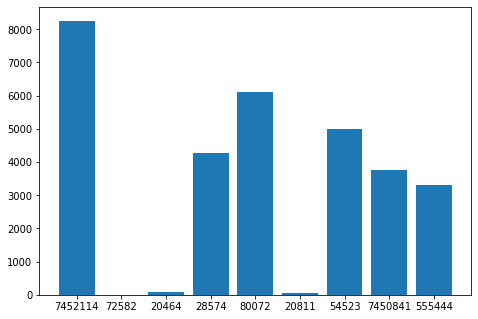

In [162]:
#Checking for class distribution in augmented data

print("Data distribution of labels:")
# cc_28586 = df[df.COMMODITY_CODE == 28586].shape[0]
cc_7452114 = df[df.COMMODITY_CODE == 7452114].shape[0] 
cc_72582 = df[df.COMMODITY_CODE == 72582].shape[0]
cc_20464 = df[df.COMMODITY_CODE == 20464].shape[0]
cc_28574 = df[df.COMMODITY_CODE == 28574].shape[0]
cc_80072 = df[df.COMMODITY_CODE == 80072].shape[0]
cc_20811 = df[df.COMMODITY_CODE == 20811].shape[0]
cc_54523 = df[df.COMMODITY_CODE == 54523].shape[0]
cc_7450841 = df[df.COMMODITY_CODE == 7450841].shape[0]
cc_555444 = df[df.COMMODITY_CODE == 555444].shape[0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
class_labels = ['7452114',   '72582',   '20464',   '28574',   '80072',   '20811',
         '54523', '7450841',  '555444']
values =[   cc_7452114,   cc_72582,   cc_20464,   cc_28574,   cc_80072,   cc_20811,
         cc_54523, cc_7450841,  cc_555444]
total = sum(values)
print(values)
ax.bar(class_labels,values)
plt.show()

In [171]:
#Appending randomly picked data samples for class labels which makes helps in balancing the class distribution

data = data.append(df[df.COMMODITY_CODE == 7452114 ].sample(n=1000, random_state=1))
data = data.append(df[df.COMMODITY_CODE == 28574 ].sample(n=3000, random_state=1))
data = data.append(df[df.COMMODITY_CODE == 80072 ].sample(n=2000, random_state=1))
data = data.append(df[df.COMMODITY_CODE == 54523 ].sample(n=2500, random_state=1))
data = data.append(df[df.COMMODITY_CODE == 7450841 ].sample(n=3000, random_state=1))
data = data.append(df[df.COMMODITY_CODE == 555444 ].sample(n=3000, random_state=1))


In [172]:
# Number of rows after appending augmented data to original data frame
data.shape

(42929, 13)

Data distribution of labels:
[5034, 5133, 4027, 1952, 5142, 5058, 2062, 4998, 4877, 4646]


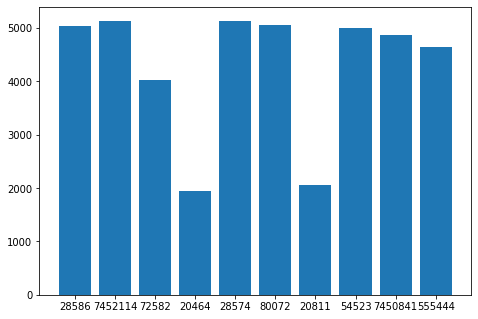

In [173]:
#Checking for class imbalance in augmented data

print("Data distribution of labels:")
cc_28586 = data[data.COMMODITY_CODE == 28586].shape[0]
cc_7452114 = data[data.COMMODITY_CODE == 7452114].shape[0] 
cc_72582 = data[data.COMMODITY_CODE == 72582].shape[0]
cc_20464 = data[data.COMMODITY_CODE == 20464].shape[0]
cc_28574 = data[data.COMMODITY_CODE == 28574].shape[0]
cc_80072 = data[data.COMMODITY_CODE == 80072].shape[0]
cc_20811 = data[data.COMMODITY_CODE == 20811].shape[0]
cc_54523 = data[data.COMMODITY_CODE == 54523].shape[0]
cc_7450841 = data[data.COMMODITY_CODE == 7450841].shape[0]
cc_555444 = data[data.COMMODITY_CODE == 555444].shape[0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
class_labels = [  '28586', '7452114',   '72582',   '20464',   '28574',   '80072',   '20811',
         '54523', '7450841',  '555444']
values =[  cc_28586, cc_7452114,   cc_72582,   cc_20464,   cc_28574,   cc_80072,   cc_20811,
         cc_54523, cc_7450841,  cc_555444]
total = sum(values)
print(values)
ax.bar(class_labels,values)
plt.show()

In [181]:
# Splitting data into training and test set

X = data['EXTENDED_DESCRIPTION']
y = data['COMMODITY_CODE']

X = X.values.tolist()
y = y.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

print('Number of training samples -',len(X_train))
print('Number of samples in test set -',len(X_test))


Number of training samples - 30050
Number of samples in test set - 12879


In [7]:
# Data pre-processing

porter = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def data_cleaning(text):
    # should return a list of tokens
    
    # word tokenisation, including punctuation removal
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # lowercasing
    tokens = [t.lower() for t in tokens]

    # stopword removal
    if True:
        stop = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop]
    
    # lemmatisation
    if True:
        lemmatiser = WordNetLemmatizer()
        tokens = [lemmatiser.lemmatize(t) for t in tokens]
        
    # stemming- works well with stop word remove
    if False:
        p_stemmer = PorterStemmer()
        tok = []
        for t in tokens:
            tok.append(p_stemmer.stem(t))
        tokens = tok
        
    tokens = [t for t in tokens if t] # ensure no empty space
    
    return tokens

In [78]:
print(data_cleaning('Smart 2 Wire W/trans Tube Blk [pmln6129a]	'))

['smart', '2', 'wire', 'w', 'trans', 'tube', 'blk', 'pmln6129a']


In [13]:
# Labels to integers 

def label2int(labels):
  y = []
  for label in labels:
    if label == 28586:
      y.append(0)
    if label == 7452114:
      y.append(1) 
    if label == 72582:
      y.append(2)  
    if label == 20464:
      y.append(3)  
    if label == 28574:
      y.append(4)  
    if label == 80072:
      y.append(5)    
    if label == 20811:
      y.append(6)    
    if label == 54523:
      y.append(7)    
    if label == 7450841:
      y.append(8)    
    if label == 555444:
      y.append(9)    
  return y


In [22]:
y_train_int = np.array(label2int(y_train))
y_test_int = np.array(label2int(y_test))

print(y_train[0])
print(y_train_int[0])

28586
0


In [12]:
#Vectorization

featureDict = {} # the global feature dictionary

def toFeatureVector(tokens):
    # return a dictionary 'featureVect' where the keys are the tokens in 'words' and the values are the number of occurrences of the tokens
    
    featureVec = {}

    for w in tokens:
        try:
            featureVec[w] += 1.0/len(tokens)
        except KeyError:
            featureVec[w] = 1.0/len(tokens)
        try:
            featureDict[w] += 1.0/len(tokens)
        except KeyError:
            featureDict[w] = 1.0/len(tokens)
    
       #  bigram binary presence 
    for i in range(1, len(tokens)):
      bigram = tokens[i-1] + " " + tokens[i]
      try:
        featureVec[bigram] = 1 #+= 1.0/len(tokens)
      except KeyError:
        featureVec[bigram] = 1 #= 1.0/len(tokens)
      try:
        featureDict[bigram] += 1.0
      except KeyError:
        featureDict[bigram] = 1.0
    return featureVec

In [30]:
# Creating training data for classifier

X_train_processed  = []
X_test_processed = []

for i in range(len(X_train)):
  X_train_processed.append((toFeatureVector(data_cleaning(X_train[i])),y_train_int[i]))

for i in range(len(X_test)):  
  X_test_processed.append((toFeatureVector(data_cleaning(X_test[i])),y_test_int[i]))

In [64]:
# Weighting classes to combat class imbalance in data

weight_for_0 = (1 / cc_28586) * (total / 10.0)
weight_for_1 = (1 / cc_7452114) * (total / 10.0)
weight_for_2 = (1 / cc_72582) * (total / 10.0)
weight_for_3 = (1 / cc_20464) * (total / 10.0)
weight_for_4 = (1 / cc_28574) * (total / 10.0)
weight_for_5 = (1 / cc_80072) * (total / 10.0)
weight_for_6 = (1 / cc_20811) * (total / 10.0)
weight_for_7 = (1 / cc_54523) * (total / 10.0)
weight_for_8 = (1 / cc_7450841) * (total / 10.0)
weight_for_9 = (1 / cc_555444) * (total / 10.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4:weight_for_4, 5:weight_for_5, 6:weight_for_6, 7:weight_for_7, 8:weight_for_8, 9:weight_for_9}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))
print('Weight for class 5: {:.2f}'.format(weight_for_5))
print('Weight for class 6: {:.2f}'.format(weight_for_6))
print('Weight for class 7: {:.2f}'.format(weight_for_7))
print('Weight for class 8: {:.2f}'.format(weight_for_8))
print('Weight for class 9: {:.2f}'.format(weight_for_9))

Weight for class 0: 0.56
Weight for class 1: 0.69
Weight for class 2: 0.71
Weight for class 3: 1.46
Weight for class 4: 1.33
Weight for class 5: 0.93
Weight for class 6: 1.38
Weight for class 7: 1.14
Weight for class 8: 1.51
Weight for class 9: 1.73


In [200]:
# Training and validating classifier 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier


# clf = tree.DecisionTreeClassifier(class_weight=class_weight)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = LogisticRegression(class_weight=class_weight, multi_class='auto')

clf = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=50,activation = 'relu',solver='adam',random_state=1)

def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('tfidf', TfidfTransformer()),('chi2', SelectKBest(chi2, k=20000)),('MLP', clf)])
    return SklearnClassifier(pipeline).train(trainData)

In [76]:
# K-fold cross-validation

def crossValidate(dataset, folds):
    shuffle(dataset)
    results = []
    foldSize = int(len(dataset)/folds)
    
    for i in range(0,len(dataset),int(foldSize)):
        print("Fold start on items %d - %d" % (i, i+foldSize))
        myTestData = dataset[i:i+foldSize]
        myTrainData = dataset[:i] + dataset[i+foldSize:]
        classifier = trainClassifier(myTrainData)
        y_true = [x[1] for x in myTestData]
        y_pred = predictLabels(myTestData, classifier)
        print(set(y_true)-set(y_pred))
        print(len(myTestData))
        results.append(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
        
    print(zip(*results))
    avgResults = [np.mean([x[0] for x in results]),
                   np.mean([x[1] for x in results]),
                   np.mean([x[2] for x in results])
                ]
    return avgResults

In [68]:
# Label predictions

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

In [201]:
# Driver code for training and cross-validation

cv_results = crossValidate(X_train_processed, 10)
print(cv_results)

Fold start on items 0 - 1135
Training Classifier...
{7}
1135
Fold start on items 1135 - 2270
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


set()
1135
Fold start on items 2270 - 3405
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


set()
1135
Fold start on items 3405 - 4540
Training Classifier...
{8, 7}
1135
Fold start on items 4540 - 5675
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{7}
1135
Fold start on items 5675 - 6810
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{8}
1135
Fold start on items 6810 - 7945
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


set()
1135
Fold start on items 7945 - 9080
Training Classifier...
{7}
1135
Fold start on items 9080 - 10215
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


set()
1135
Fold start on items 10215 - 11350
Training Classifier...
set()
1135
Fold start on items 11350 - 12485
Training Classifier...
set()
7
[0.968267330023843, 0.965478574289147, 0.9655354789910107]


In [202]:
functions_complete = True  # set to True after cross validation
if functions_complete:
    print(X_test_processed[0])   # first test data instance
    classifier = trainClassifier(X_train_processed)  # training the classifier
    testTrue = [t[1] for t in X_test_processed]   # ground-truth labels from the data
    testPred = predictLabels(X_test_processed, classifier)  # predicted labels
    finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluation of predictions on test set
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % finalScores[:3])

({'sound': 0.16666666666666666, 'signal': 0.16666666666666666, 'pul3m03': 0.16666666666666666, 'visor': 0.16666666666666666, 'mount': 0.16666666666666666, 'bracket': 0.16666666666666666, 'sound signal': 1, 'signal pul3m03': 1, 'pul3m03 visor': 1, 'visor mount': 1, 'mount bracket': 1}, 9)
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done training!
Precision: 0.970637
Recall: 0.969803
F Score:0.969271


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Visualizing predictions on test set

def confusion_matrix_heatmap(y_test, preds):
    labels = [28586, 7452114,   72582,   20464,   28574,   80072,   20811,
         54523, 7450841,  555444]
    for label in y_test:
      label = labels[label]
    for label in preds:
      label = labels[label]  
    cm = confusion_matrix(y_test, preds, list(set(y_test)))
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

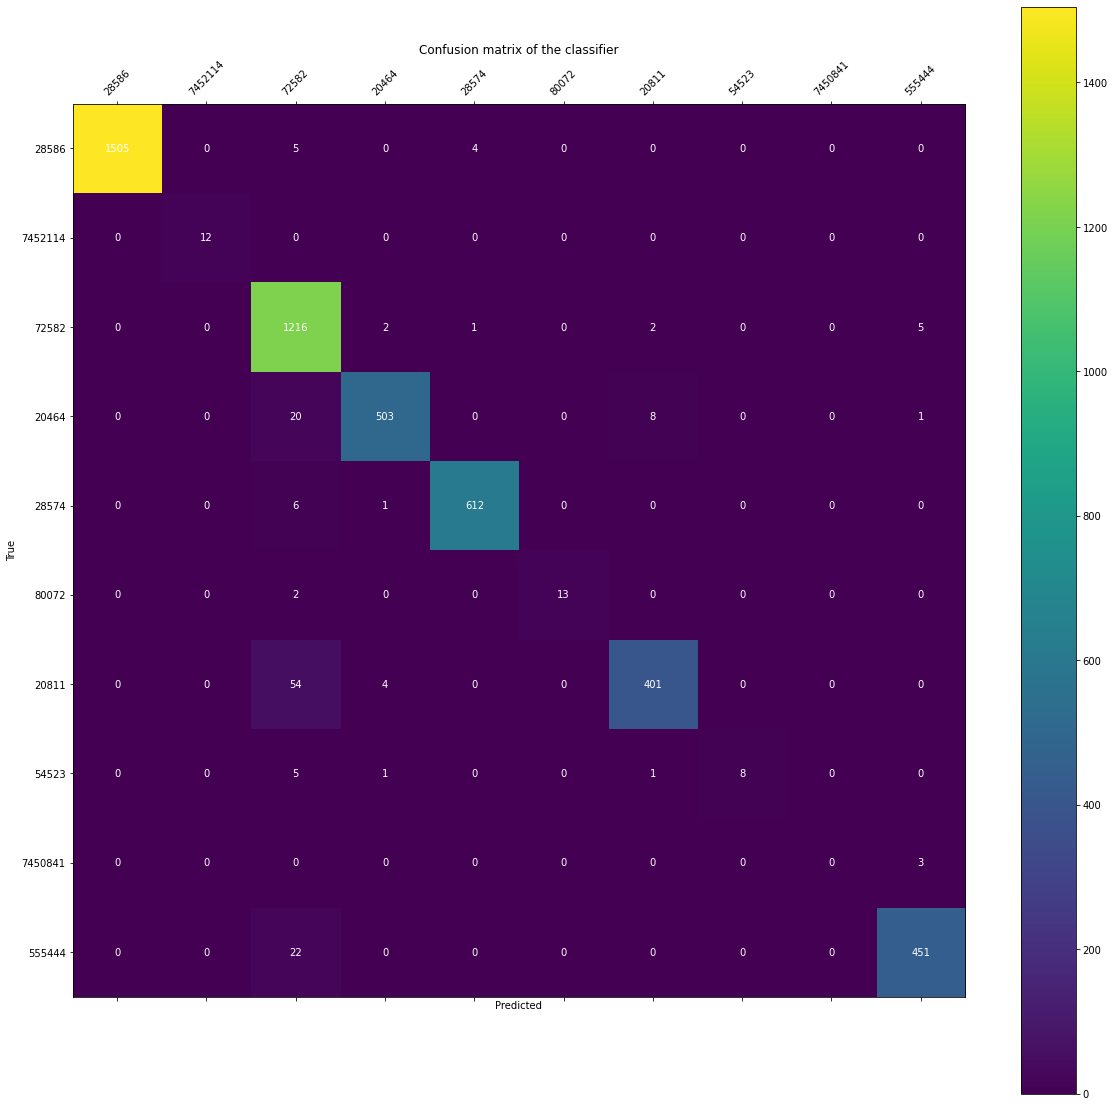

In [203]:

confusion_matrix_heatmap(testTrue, testPred)    